In [1]:
import re
import pandas as pd
import bs4
import requests
import spacy
from spacy import displacy
nlp = spacy.load('en_core_web_sm')

from spacy.matcher import Matcher 
from spacy.tokens import Span 

import networkx as nx

import matplotlib.pyplot as plt
from tqdm import tqdm

pd.set_option('display.max_colwidth', 200)
%matplotlib inline

In [2]:
candidate_sentences = pd.read_csv("text_files/wiki_sentences_v2.csv")
candidate_sentences.shape

(4318, 1)

In [3]:
candidate_sentences['sentence'].sample(5)

4083                                      both owners had been seeking unspecified damages.
1914    both zodiac and this film are co-productions of paramount pictures and warner bros.
4282                                          hat's the whole magic of the spider-man idea.
2596                                                    they both depict a realistic story.
3045                          biographical films may be less lavish versions of this genre.
Name: sentence, dtype: object

In [4]:
def get_entities(sent):
    ent1 = ""
    ent2 = ""

    prv_tok_dep = ""    # dependency tag of previous token in the sentence
    prv_tok_text = ""   # previous token in the sentence

    prefix = ""
    modifier = ""
    
    for tok in nlp(sent):
        ## chunk 2
        # if token is a punctuation mark then move on to the next token
        if tok.dep_ != "punct":
          # check: token is a compound word or not
          if tok.dep_ == "compound":
            prefix = tok.text
            # if the previous word was also a 'compound' then add the current word to it
            if prv_tok_dep == "compound":
              prefix = prv_tok_text + " "+ tok.text

          # check: token is a modifier or not
          if tok.dep_.endswith("mod") == True:
            modifier = tok.text
            # if the previous word was also a 'compound' then add the current word to it
            if prv_tok_dep == "compound":
              modifier = prv_tok_text + " "+ tok.text

          ## chunk 3
          if tok.dep_.find("subj") == True:
            ent1 = modifier +" "+ prefix + " "+ tok.text
            prefix = ""
            modifier = ""
            prv_tok_dep = ""
            prv_tok_text = ""      

          ## chunk 4
          if tok.dep_.find("obj") == True:
            ent2 = modifier +" "+ prefix +" "+ tok.text

          ## chunk 5  
          # update variables
          prv_tok_dep = tok.dep_
          prv_tok_text = tok.text
  #############################################################
    return [ent1.strip(), ent2.strip()]

In [5]:
get_entities("the drawdown process is governed by astm standard d823")

['drawdown  process', 'astm standard astm d823']

In [6]:
entity_pairs = []

for i in tqdm(candidate_sentences["sentence"]):
  entity_pairs.append(get_entities(i))

100%|██████████| 4318/4318 [00:33<00:00, 130.19it/s]


In [7]:
candidate_sentences[10:20]

,sentence
10,we went through all these tests and things
11,m global was also circling to bid for the film's international sales rights.
12,canadian musician robbie robertson supervised the soundtrack.
13,it features both original and existing music tracks.
14,it is the worst reviewed film in the franchise.
15,but she injures quicksilver and accidentally kills mystique before flying away.
16,military forces tasked with her arrest.
17,the train is attacked by vuk and her d'bari forces.
18,"kota eberhardt portrays telepath selene gallio,"
19,"singer did not return to direct the sequel, x-men:"


In [8]:
entity_pairs[10:20]

[['we', 'tests'],
 ['m global', 'international sales rights'],
 ['robbie robertson', 'soundtrack'],
 ['it', 'original music tracks'],
 ['it', 'reviewed  franchise'],
 ['she', 'accidentally  mystique'],
 ['', 'military  arrest'],
 ['train', 'vuk'],
 ['telepath', 'gallio'],
 ['singer', 'men']]

In [9]:
def get_relation(sent):

  doc = nlp(sent)

  # Matcher class object 
  matcher = Matcher(nlp.vocab)

  #define the pattern 
  pattern = [{'DEP':'ROOT'}, 
            {'DEP':'prep','OP':"?"},
            {'DEP':'agent','OP':"?"},  
            {'POS':'ADJ','OP':"?"}] 

  matcher.add("matching_1", None, pattern) 

  matches = matcher(doc)
  k = len(matches) - 1

  span = doc[matches[k][1]:matches[k][2]] 

  return(span.text)


In [10]:
get_relation("John completed the task")

'completed'

In [11]:
relations = [get_relation(i) for i in tqdm(candidate_sentences['sentence'])]

100%|██████████| 4318/4318 [00:30<00:00, 139.98it/s]


In [12]:
print(relations)

['decides', 'heard in', 'paralyzed by', 'set on', 'wails with', "'s", 'joined', 'revealed', 'revealed as', 'tried', 'went through', 'circling', 'supervised', 'features', 'is', 'injures', 'forces', 'attacked by', 'portrays', 'return', 'stand', 'considered for', 'served as', 'completed on', 'released', 'released', 'distributed by', 'ended', 'chandler', 'dedicated to executive', 'approach former', 'frees', 'disowns', 'appears as', 'credited as', 'stated', 'empathizing with', 'was', 'contributed to', 'took', 'changed', 'became', 'look like big', 'perform', 'managed', 'released on', 'written by', 'conducted by', 'released', 'released', 'scheduled', 'offered in', 'includes', 'include limited', 'are ready', 'was', 'tend', 'include', 'prevalent in typical', 'is', 'are', 'had many', 'supervises', 'oversee', 'credited', 'start in', 'started as', 'attended', 'use different', 'take', 'equipped with sound', 'designed for', 'cooperates with', 'femis in', 'is', 'presented in', 'presented in', 'return

In [24]:
pd.Series(relations).value_counts()[:50]

is               370
was              297
released on       87
include           73
were              71
are               71
released          40
's                38
composed by       35
have              31
became            31
has               31
become            29
released in       27
included          26
produced          22
called            22
had               20
considered        20
made              20
been              18
be                18
used              17
scheduled         17
directed by       16
stars             16
written by        15
set               14
hired             14
wrote             14
produced by       14
went              13
introduced in     13
received          13
wanted            12
won               11
began in          11
began             11
sold              10
gave              10
features          10
known as           9
includes           9
used in            9
gives              9
shot in            9
reported           9
opened       

In [13]:
# extract subject
source = [i[0] for i in entity_pairs]

# extract object
target = [i[1] for i in entity_pairs]

kg_df = pd.DataFrame({'source':source, 'target':target, 'edge':relations})
print(type(kg_df))

<class 'pandas.core.frame.DataFrame'>


In [26]:
# create a directed-graph from a dataframe
G=nx.from_pandas_edgelist(kg_df, "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

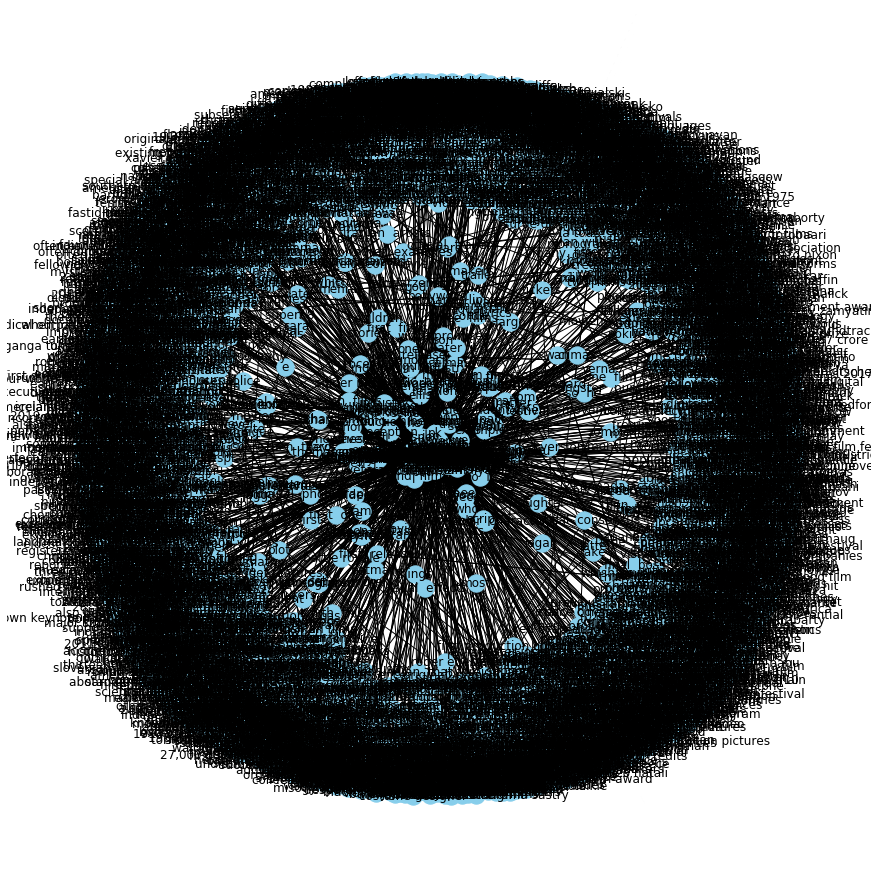

In [27]:
plt.figure(figsize=(12,12))

pos = nx.spring_layout(G)
nx.draw(G, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

In [15]:
G=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="composed by"], "source"=="robbie robertson", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5) # k regulates the distance between nodes
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

KeyError: False

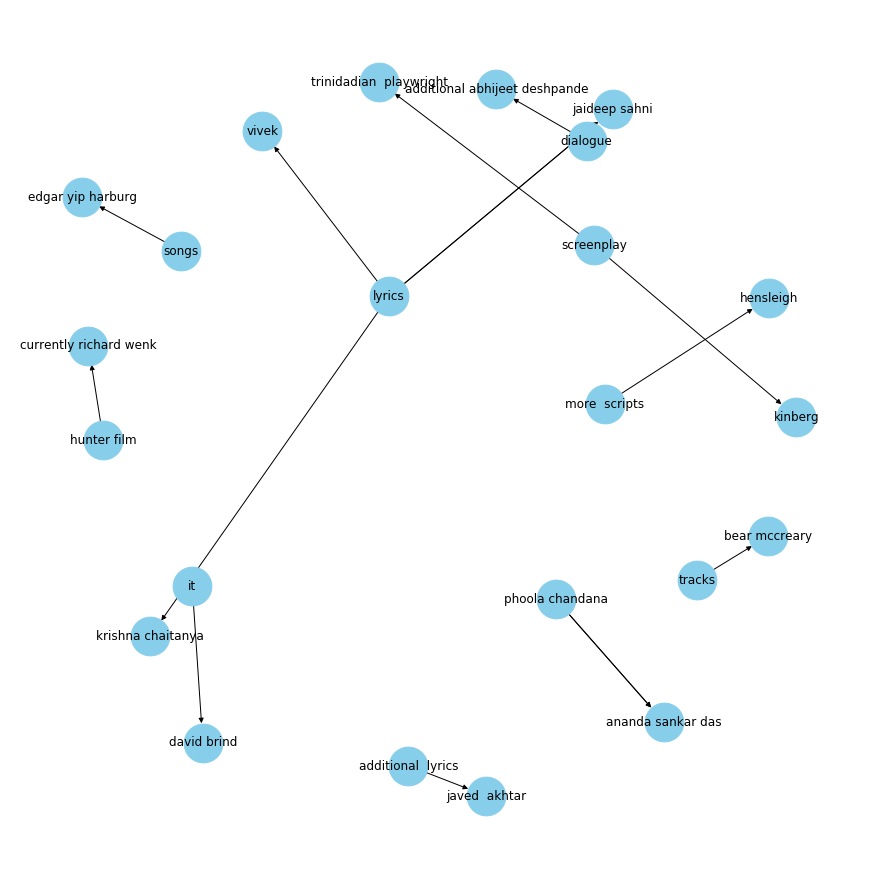

In [29]:
G=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="written by"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5)
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

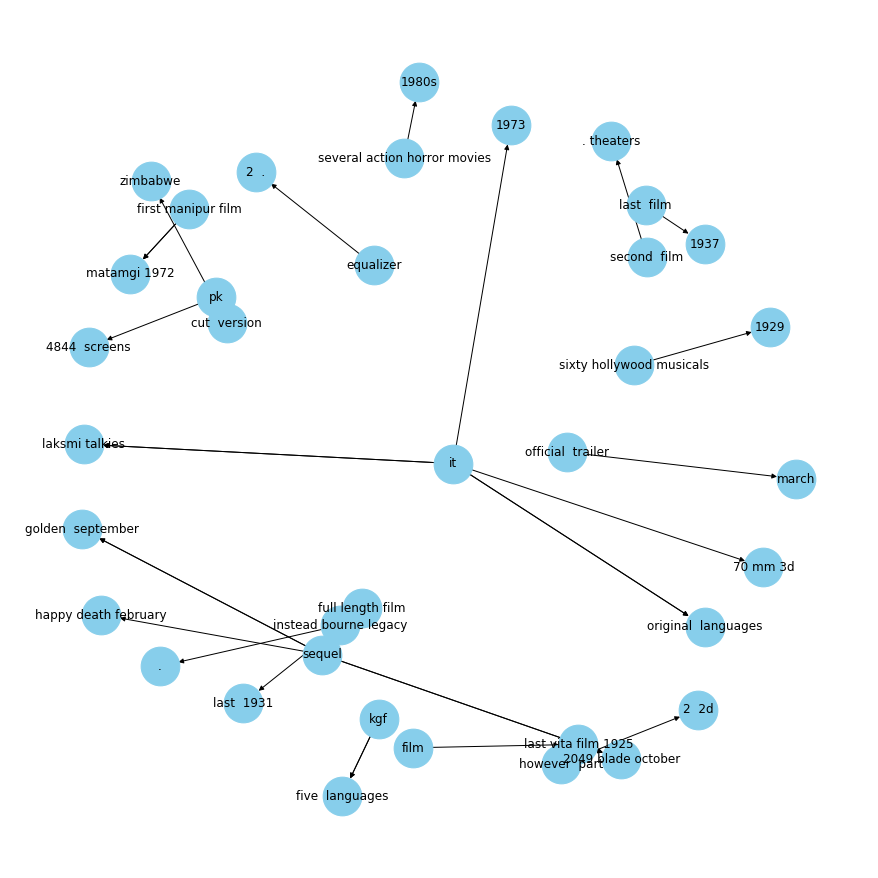

In [30]:
G=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="released in"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5)
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()